## Final Notebook

Please fill out:
* Student name: Andrew Levinton
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Ahbineet Kulkarni
* Blog post URL:


## Statsmodels debug
- This is because statsmodels was having version issues. this is a workaround
- The code below re-publishes the existing (but private) _centered function as a public attribute to the module already imported in RAM.

In [887]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

## Import necessary libraries

In [888]:
# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# data visualiztion
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# regression modeling
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error


import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")



plt.style.use('ggplot')

## Define Functions

In [889]:
# Grabbing vifs
def get_vifs(data):
    # Get a list of the column names
    cols = data.columns

    # Create an empty DataFrame to hold the VIF results
    vif_data = pd.DataFrame()

    # Loop through each column and calculate the VIF
    for i in range(len(cols)):
        vif = variance_inflation_factor(data[cols].values, i)
        vif_data = vif_data.append({'Variable': cols[i], 'VIF': vif}, ignore_index=True)

    # Print the VIF results
    return print(vif_data)


# get ols model and plot residual distribution
def get_OLS_model(name, X, y):
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    model_residual = results.resid
    
    return print(results.summary()), plt.suptitle(f'Residual distribution for {name} model'), sns.distplot(model_residual), plt.show()



#get qq and histogram plots 
def plot_hist_qq(df, target_col):
    """
    Creates a histogram and QQ-plot for a given dataframe and target column.

    Args:
        df (pandas.DataFrame): The dataframe to plot.
        target_col (str): The name of the target column.

    Returns:
        None
    """
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot histogram on the first subplot
    axs[0].hist(df[target_col], bins=30)
    axs[0].set_xlabel(target_col)
    axs[0].set_ylabel('Frequency')

    # Plot QQ-plot on the second subplot
    stats.probplot(df[target_col], plot=axs[1])
    axs[1].set_xlabel('Theoretical quantiles')
    axs[1].set_ylabel('Sample quantiles')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()
    
# getting qqplots from stats model
def get_model_qqplots(data, y):    
    # Set up the plot grid
    fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25, 18))

    # Loop through each variable in the DataFrame
    for i, var in enumerate(data.columns):
        # Fit a linear regression model
        X = sm.add_constant(data[var])
        model = sm.OLS(y, X).fit()

        # Calculate the residuals
        resid = model.resid

        # Create a QQ plot
        sm.qqplot(resid, line='s', ax=axes[i//6, i%6])
        axes[i//6, i%6].set_title(var)

    plt.tight_layout()
    plt.show()
    
def get_log_mse(X,y):
    model = LinearRegression()
    model.fit(X, y)

    # Calculate the predicted values of the target variable using the linear model
    y_pred = model.predict(X)
    
    return mean_squared_log_error(y, y_pred)

def get_error_metrics(X,y):
    # Fit a linear regression model with an intercept term
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()

    # Get the predicted values for the input data
    y_pred = results.predict(sm.add_constant(X))

    # Calculate MSE
    mse = np.mean((y - y_pred)**2)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    # Calculate MAPE
    mape = np.mean(np.abs((y - y_pred) / y)) * 100

    print("Mean Squared Error: ", mse)
    print("Root Mean Squared Error: ", rmse)
    print("Mean Average Percentage Error: ", mape,'%')


## Read in dataset, check length

In [890]:
cd data

C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_2\Housing_Linear_Model_Project\data


In [891]:
df = pd.read_csv('kc_house_data.csv')
len(df)

30155

## Dataset timeline

In [892]:
df['yr_built'].min(), df['yr_built'].max()

(1900, 2022)

### Checking dtypes

In [893]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

## Linear Model must meet the following assumptions:

### Simple Linear Regression on select features
Assumption check:
- Is it linear?
    - Scatter plots
- Is it normal?
    - histogram
    - QQ-plot
    
- Is it homoscedastic?
    - Durbin-Watson Score
- Does the model present with multicollinearity?

## The process for building this linear model:
- Prep data for linear model regression: This involves dropping null values, dropping "bad data", as well as engineering features to assist in assuming linearization
- Key scores to look at:
- `R-Squared ( or the coefficient of determination)` - a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. In other words, r-squared shows how well the data fit the regression model (the goodness of fit).
- `Correlation coefficients` - check to see what variables seem relatable to the target variable (price)
- `residual plots` - check how far data compares to the mean. Data should be normally distributed to avoid skewness of the mean
- `variance inflation factor` - level of statistical skew
- `Root mean squared erro`r - how far predictions fall from measured true values using Euclidean distance.
- `pvalues of independent variables` - measures how statistically significant the independent variables are

## Data Preparation

## Dropping nullls

In [894]:
df.dropna(inplace=True)

### Recheck length

In [895]:
len(df)

30111

### Looking at Washington state

In [896]:
df['address'] = df['address'].str.lower()

In [897]:
df = df[df['address'].str.contains('washington')]

In [898]:
len(df)

29208

## Grabbing Zipcodes

In [899]:
df['zipcode'] = df['address'].apply(lambda x: x.split(',')[2].split(' ')[-1])

In [900]:
df['zipcode'] = df['zipcode'].astype(str)

In [901]:
df['zipcode'].unique()

array(['98055', '98133', '98178', '98118', '98027', '98166', '98030',
       '98023', '98019', '98144', '98031', '98092', '98103', '98006',
       '98136', '98007', '98038', '98057', '98077', '98126', '98053',
       '98039', '98107', '98008', '98155', '98168', '98199', '98004',
       '98045', '98052', '98011', '98002', '98033', '98116', '98198',
       '98125', '98001', '98112', '98034', '98056', '98059', '98005',
       '98040', '98014', '98106', '98029', '98122', '98003', '98117',
       '98042', '98119', '98065', '98022', '98072', '98058', '98108',
       '98115', '98074', '98105', '98024', '98146', '98109', '98102',
       '98028', '98188', '98177', '98075', '98010', '98148', '98047',
       '98032', '98070', '98051', '98288', '98354', '98272', '98296',
       '98271', '98050', '63090', 'seattle', '98387', '15301', '98251',
       '98223', '98338', '98224', '98372', '98663', '99202', '99403',
       '98422', '99203', '99223', '98270'], dtype=object)

## Categorizing waterfronts

In [902]:
duwamish = ['98168']
elliot_bay_zips= ['98119','98104','98129','98132','98127','98125','98195','98101','98134','98170','98139','98131','98181','98121'] 
puget_sound = ['98071','98083','98013','98070','98031','98131','98063','98195','98207','98190'] 
lake_union = ['98109']
ship_canal = ['00000'] 
lake_washington = ['98072','98077'] 
lake_sammamish = ['98074','98075','98029'] 
other = ['00000']
river_slough_waterfronts = ['00000']

df['waterfront_loc'] = df['zipcode'].apply(lambda x: 'Duwamish' if x=='98168'\
                                          else 'Elliot Bay' if x in elliot_bay_zips\
                                          else 'Puget Sound' if x in puget_sound\
                                          else 'Lake Union' if x in lake_union\
                                          else 'ship canal' if x in ship_canal\
                                          else 'Lake Washington' if x in lake_washington\
                                          else 'Lake Sammamish' if x in lake_sammamish\
                                          else 'other')

In [903]:
df['waterfront_loc'].value_counts()

other              25497
Lake Sammamish      1159
Elliot Bay           730
Puget Sound          721
Lake Washington      589
Duwamish             383
Lake Union           129
Name: waterfront_loc, dtype: int64

## Filter by state of Washington Zipcodes (assuming seattle is its own zipcode)

In [904]:
df = df[df['zipcode'].str.startswith('98') | df['zipcode'].str.contains('seattle')]

## One Hot Encoding Waterfronts

In [905]:
waterfront_dummies = pd.get_dummies(df['waterfront_loc'], prefix='water', drop_first=True)

In [906]:
waterfront_dummies

,water_Elliot Bay,water_Lake Sammamish,water_Lake Union,water_Lake Washington,water_Puget Sound,water_other
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1
...,...,...,...,...,...,...
30150,0,0,0,0,0,1
30151,0,0,0,0,0,1
30152,0,0,0,0,0,1
30153,0,0,0,0,0,1


In [907]:
len(df) 

29200

In [908]:
len(df) == len(waterfront_dummies)

True

In [909]:
df = pd.concat([df,waterfront_dummies], axis=1)

## replacing seattle with seattle zipcode

In [910]:
df['zipcode'] = df['zipcode'].apply(lambda x: '98101' if x=='seattle' else x)

## recheck zipcodes

In [911]:
df['zipcode'].unique()

array(['98055', '98133', '98178', '98118', '98027', '98166', '98030',
       '98023', '98019', '98144', '98031', '98092', '98103', '98006',
       '98136', '98007', '98038', '98057', '98077', '98126', '98053',
       '98039', '98107', '98008', '98155', '98168', '98199', '98004',
       '98045', '98052', '98011', '98002', '98033', '98116', '98198',
       '98125', '98001', '98112', '98034', '98056', '98059', '98005',
       '98040', '98014', '98106', '98029', '98122', '98003', '98117',
       '98042', '98119', '98065', '98022', '98072', '98058', '98108',
       '98115', '98074', '98105', '98024', '98146', '98109', '98102',
       '98028', '98188', '98177', '98075', '98010', '98148', '98047',
       '98032', '98070', '98051', '98288', '98354', '98272', '98296',
       '98271', '98050', '98101', '98387', '98251', '98223', '98338',
       '98224', '98372', '98663', '98422', '98270'], dtype=object)

In [912]:
len(df['zipcode'].unique())

89

## Adding in Engineered Zipcode Data Generated from GreatSchools API

The csv file that is being imported was generated using an extensive process of requests and data aggregation of school ratings by zipcode. To view the process of retrieval and aggregation please visit the file Final_Exploratory_Data_Analysis.ipynb in the notebooks folder.

In [913]:
cd ..

C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_2\Housing_Linear_Model_Project


In [914]:
school_ratings = pd.read_csv('school_ratings_by_zipcode_.csv')
school_ratings['zipcode'] = school_ratings['zipcode'].astype(str)

In [915]:
school_ratings

,zipcode,rating
0,98001,4.000000
1,98002,3.888889
2,98004,7.666667
3,98005,7.333333
4,98006,8.666667
...,...,...
68,98664,3.500000
69,98682,3.333333
70,98683,5.600000
71,98684,3.555556


## Assigning average school ratings to corresponding zipcodes

In [916]:
# Create a dictionary from the zipcode dataframe
zip_dict = school_ratings.set_index('zipcode')['rating'].to_dict()

# Load your larger dataframe


# Assign the ratings from the zipcode dictionary to the large dataframe
df['school_rating'] = df['zipcode'].apply(lambda x: zip_dict.get(x, None))

# The above line applies the lambda function to each element of the 'zipcode' column of the large dataframe. 
# If the zipcode is present in the zip_dict, its corresponding rating is assigned to the 'rating' column. 
# If not, None is assigned.

# You can then save the updated large dataframe to a new csv file
df['school_rating'].isnull().sum()

8932

## Filling nulls with mean value

In [917]:
mean_val = df['school_rating'].mean()
med_val = df['school_rating'].median()

In [918]:
mean_val, med_val

(5.937337959170456, 6.0)

In [919]:
df['school_rating'] = df['school_rating'].fillna(mean_val)

In [920]:
df['school_rating'].isnull().sum()

0

## Observing correlation matrix for possible features that can be used with the price

In [921]:
df.corr()['price'].abs().sort_values(ascending=False)

price                    1.000000
sqft_living              0.616741
sqft_above               0.546108
bathrooms                0.488039
school_rating            0.364442
sqft_patio               0.317623
lat                      0.296212
bedrooms                 0.290994
sqft_garage              0.267477
sqft_basement            0.246548
floors                   0.199285
water_Lake Sammamish     0.141426
yr_built                 0.105877
sqft_lot                 0.086790
yr_renovated             0.085506
long                     0.081940
water_Lake Washington    0.070383
water_Puget Sound        0.068457
water_other              0.064781
water_Lake Union         0.035352
id                       0.030237
water_Elliot Bay         0.004859
Name: price, dtype: float64

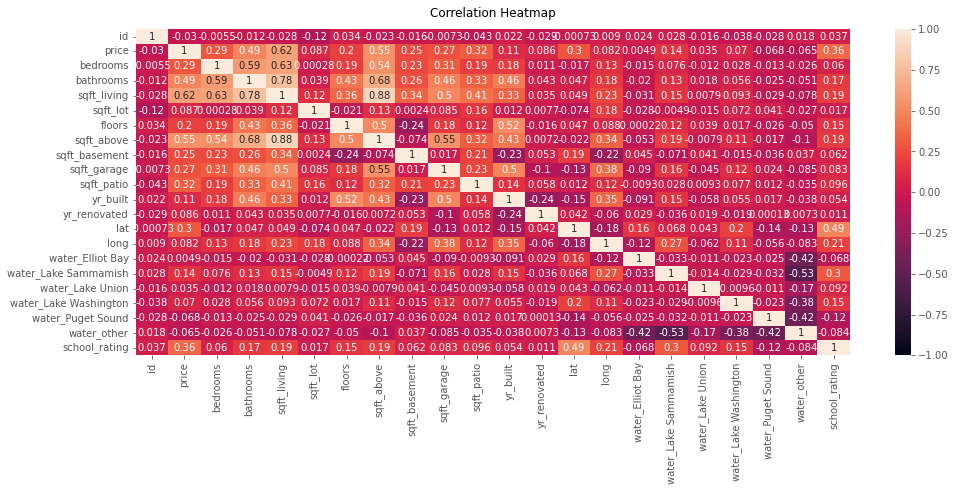

In [922]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


### Observations
- At first glance, it appears that sqft_living, sqft_above and bathrooms are the strongest correlated features to the price. 
- Further investigation is needed to measure the validity of the variables. They may be correlated with the price due to skewness or other factors that can make the correlation a deceptively "good" feature.
- To investigate further, we will monitor the Variance Inflation Factor(VIF) to address the issue of multicollinearity.

## Changing categorical variables to numerical columns - this needs to be done if we want to use them in a linear model

In [923]:
#extracting grade as an integer
df['grade'] = df['grade'].apply(lambda x: int(str(x.split(' ')[0])))

# replacing conditions with values
cond_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
df.condition.replace(to_replace=cond_dict,inplace=True)

#changing date to datetime object, get day and month
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

df['day_of_year'] = df['date'].dt.dayofyear

## Recheck dtypes

In [924]:
df.dtypes

id                                int64
date                     datetime64[ns]
price                           float64
bedrooms                          int64
bathrooms                       float64
sqft_living                       int64
sqft_lot                          int64
floors                          float64
waterfront                       object
greenbelt                        object
nuisance                         object
view                             object
condition                         int64
grade                             int64
heat_source                      object
sewer_system                     object
sqft_above                        int64
sqft_basement                     int64
sqft_garage                       int64
sqft_patio                        int64
yr_built                          int64
yr_renovated                      int64
address                          object
lat                             float64
long                            float64


### Extracting Numerical Predictors by filtering dtypes

In [925]:
df.dtypes.unique()

array([dtype('int64'), dtype('<M8[ns]'), dtype('float64'), dtype('O'),
       dtype('uint8')], dtype=object)

In [926]:
# categorizing dtypes
numerical_types = ['int64','float64']
numerical_predictors = list(df.select_dtypes(include=numerical_types))
numerical_predictors

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'school_rating',
 'month',
 'day_of_year']

### Create dataframe of numerical values

In [927]:
# df[numerical_predictors] selects only numerical columns
df_numerical = df[numerical_predictors]

In [928]:
df_numerical.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'sqft_garage', 'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'school_rating', 'month', 'day_of_year'],
      dtype='object')

In [929]:
len(df_numerical)

29200

In [930]:
len(waterfront_dummies)

29200

## Dropping price to isolate predictors

In [931]:
df_numerical = df_numerical.drop(['id','price'],axis=1)

In [932]:
df_numerical['floors'] = df['floors'].astype(float)

### Calculating variance inflation factor [VIF]

#### VIF levels:

- Good: VIF <= 5

- Moderate/Questionable: VIF >=5 and VIF <= 10

- Throw out: VIF >= 10


In [933]:
print(get_vifs(df_numerical))

         Variable            VIF
0        bedrooms      24.784656
1       bathrooms      26.274063
2     sqft_living     119.813949
3        sqft_lot       1.140732
4          floors      17.198465
5       condition      31.166852
6           grade     133.745651
7      sqft_above      92.881318
8   sqft_basement       7.075247
9     sqft_garage       4.672476
10     sqft_patio       2.240448
11       yr_built    9230.201222
12   yr_renovated       1.210978
13            lat  154765.470827
14           long  165297.345977
15  school_rating      26.080014
16          month     697.154476
17    day_of_year     612.158491
None


### It appears at first glance that the data only yields a small set of independent variables that are not highly collinear with eachother. This will be looked at again after the removal of outliers, and the transformation of data. 

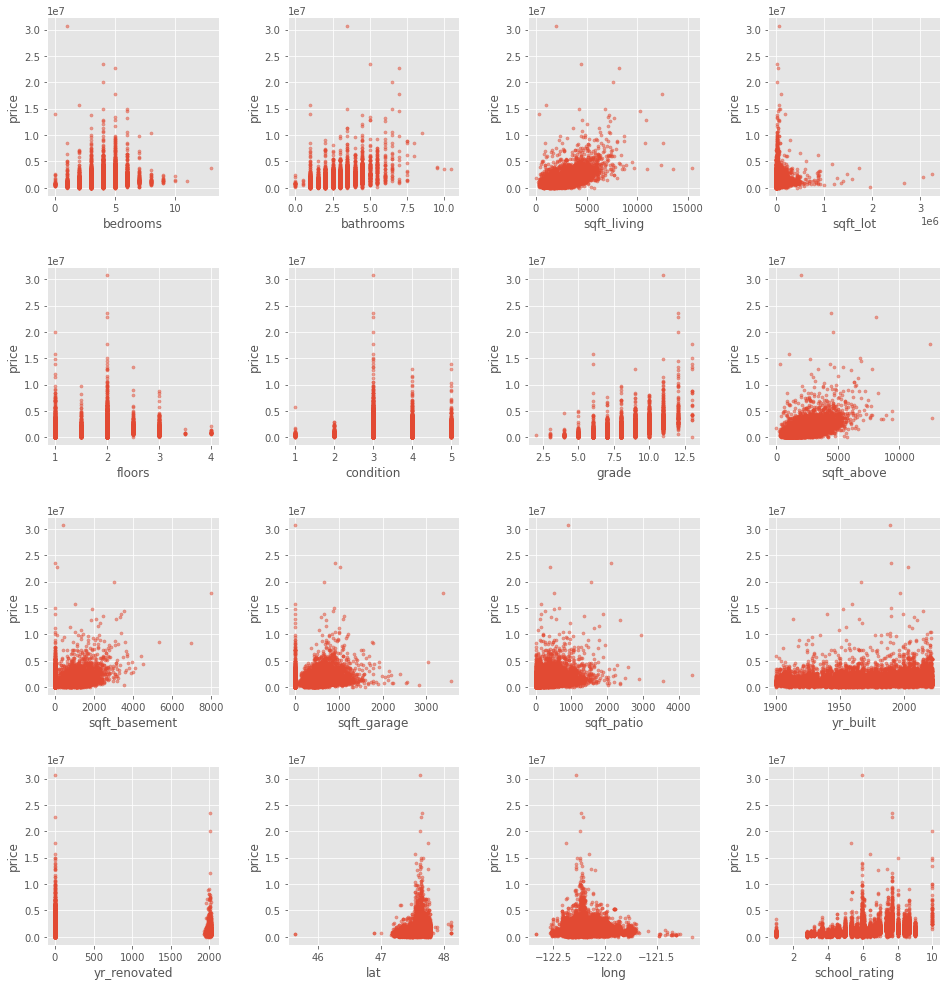

In [934]:
# Specify the dependent variable and independent variables
y_col = 'price'
x_cols = [col for col in df_numerical.columns if col != y_col][:16]  # Use the first 16 independent variables

# Create scatter plot matrix
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, x_var in enumerate(x_cols):
    row, col = divmod(i, 4)
    axs[row, col].scatter(df_numerical[x_var], df[y_col], alpha=0.5, s=10)
    axs[row, col].set_xlabel(x_var)
    axs[row, col].set_ylabel(y_col)

# Adjust plot layout
fig.subplots_adjust(top=0.93, hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

### Extracting Categorical String Predictors

In [935]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29200 entries, 0 to 30154
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     29200 non-null  int64         
 1   date                   29200 non-null  datetime64[ns]
 2   price                  29200 non-null  float64       
 3   bedrooms               29200 non-null  int64         
 4   bathrooms              29200 non-null  float64       
 5   sqft_living            29200 non-null  int64         
 6   sqft_lot               29200 non-null  int64         
 7   floors                 29200 non-null  float64       
 8   waterfront             29200 non-null  object        
 9   greenbelt              29200 non-null  object        
 10  nuisance               29200 non-null  object        
 11  view                   29200 non-null  object        
 12  condition              29200 non-null  int64         
 13  g

In [936]:
categorical_types = ['O']
categorical_predictors = list(df.select_dtypes(include=categorical_types))
categorical_predictors

['waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'heat_source',
 'sewer_system',
 'address',
 'zipcode',
 'waterfront_loc']

In [937]:
df_categorical = df[categorical_predictors]

In [938]:
df_categorical

,waterfront,greenbelt,nuisance,view,heat_source,sewer_system,address,zipcode,waterfront_loc
0,NO,NO,NO,NONE,Gas,PUBLIC,"2102 southeast 21st court, renton, washington ...",98055,other
1,NO,NO,YES,AVERAGE,Oil,PUBLIC,"11231 greenwood avenue north, seattle, washing...",98133,other
2,NO,NO,NO,AVERAGE,Gas,PUBLIC,"8504 south 113th street, seattle, washington 9...",98178,other
3,NO,NO,NO,AVERAGE,Gas,PUBLIC,"4079 letitia avenue south, seattle, washington...",98118,other
4,NO,NO,YES,NONE,Electricity,PUBLIC,"2193 northwest talus drive, issaquah, washingt...",98027,other
...,...,...,...,...,...,...,...,...,...
30150,NO,NO,NO,NONE,Oil,PUBLIC,"4673 eastern avenue north, seattle, washington...",98103,other
30151,NO,NO,NO,FAIR,Gas,PUBLIC,"4131 44th avenue southwest, seattle, washingto...",98116,other
30152,NO,NO,YES,NONE,Gas,PUBLIC,"910 martin luther king jr way, seattle, washin...",98122,other
30153,NO,NO,NO,NONE,Gas,PUBLIC,"17127 114th avenue southeast, renton, washingt...",98055,other


# Model #1

In [939]:
model_data = df_numerical

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     1814.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:30:25   Log-Likelihood:            -4.3066e+05
No. Observations:               29200   AIC:                         8.614e+05
Df Residuals:                   29181   BIC:                         8.615e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.813e+07   3.98e+06    -19.626

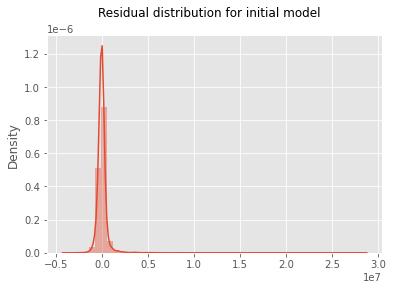

(None,
 Text(0.5, 0.98, 'Residual distribution for initial model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [940]:
get_OLS_model('initial',X = model_data, y = df['price'])

## Getting RMSE(Root Mean Squared Error), MAE(Mean Absolute Error), and MAPE(Mean Absolute Percentage Error)

In [941]:
from sklearn.metrics import mean_squared_error

def get_rmse(X, y):
    model = sm.OLS(y, sm.add_constant(X))
    result = model.fit()

    # Calculate the predicted values of the target variable using the linear model
    y_pred = result.predict(sm.add_constant(X))

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    return rmse
get_rmse(model_data,df['price'])

615147.2440023683

In [942]:
get_error_metrics(model_data,df['price'])

Mean Squared Error:  378406131803.7115
Root Mean Squared Error:  615147.2440023702
Mean Average Percentage Error:  38.34330476891375 %


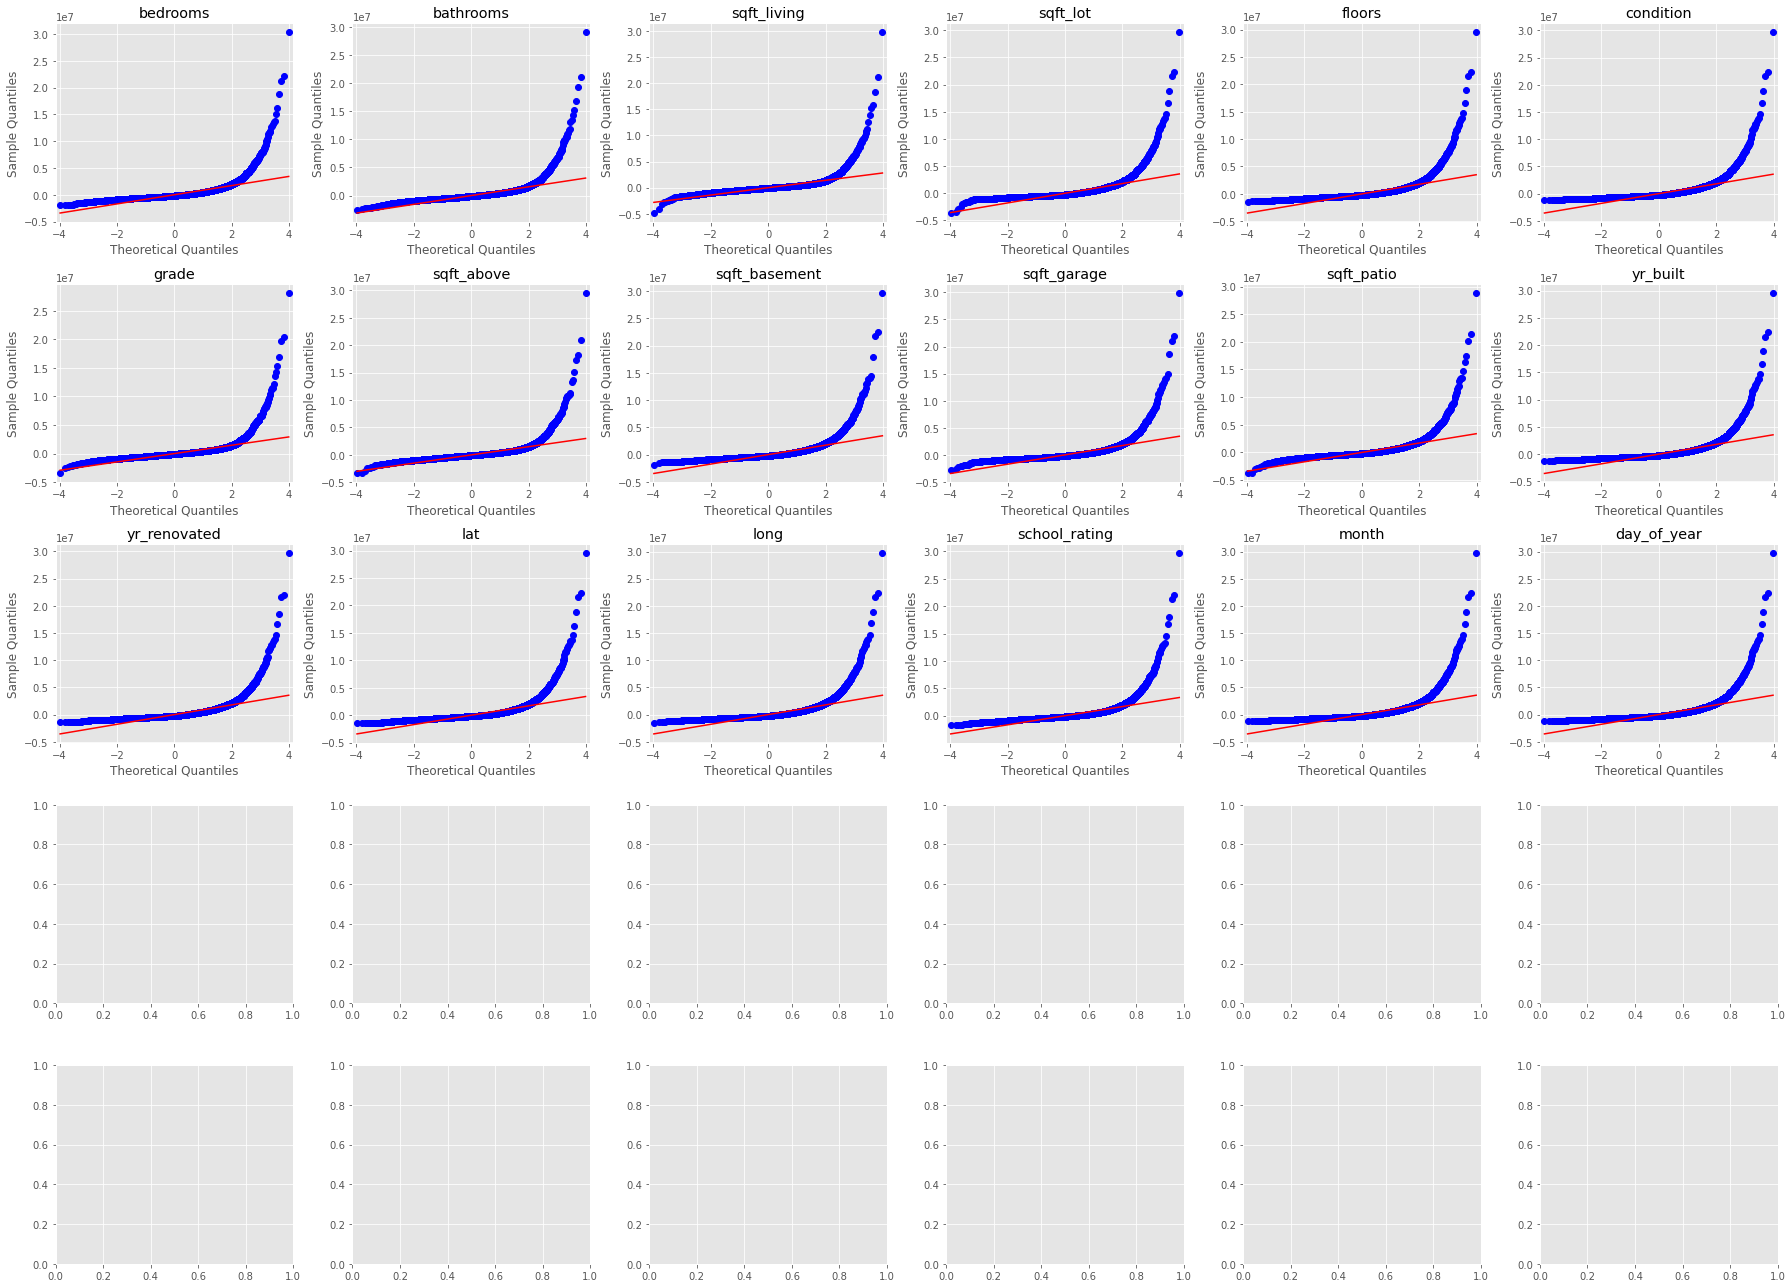

In [943]:
get_model_qqplots(model_data, df['price'])

# Observations

p_value > 0.05

- `longitude`**
- `month`

 - month was not anticipated as an effective predictor because it is not typical for the season to affect the sale price of a house
 
 Additional Observations:
 - The adjusted r-squared value is .514, indicating that his model can explain approximately 51.4% of the data.
 -  Skew: A kurtosis value between -2 and +2 is good to prove normalcy. The skew score is 10.065, indicating that this model is heavily skewed. This will be addressed through transformations to normalize the data. 

## Possible Improvements to be made to model:
    - dropping of variables that are not statistically significant (Pval > 0.05)
    - addition of categorial variables(one hot encoded)
    - location would possibly be the most interesting variable, mapped against the waterfront or view variable
    - transformation of data to satisfy normality assumption -ex: log transformation or square root transformation
    - removal of outliers: Outliers in this case will be considered to be any data falling greater than 
      3 standard deviations outside the mean
### Goals
    - improve skewness - removal of outliers, transform data
    - improve on homoscedasticity
    - increase rsquared to promote higher level explanation of data from model
    - remove collinearity - all VIFs less than a value of 5. 

# Categorical data Exploratory Analysis and Engineering

The goal of this section will be to add in meaningful categorical data to the model, to be OneHotEncoded once prepped. For this, we first look at the categorical data. 

In [944]:
df_categorical.columns

Index(['waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source',
       'sewer_system', 'address', 'zipcode', 'waterfront_loc'],
      dtype='object')

## Possible categorical variables of interest: 

* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `address` - The street address

The grade and condition are already onehotencoded in the model and could be changed to a numerical variable, so this part of the analysis will focus on the string categorical variables. 

The address appears to be the most interesting variable in the batch because it can be mapped against the waterfronts or the quality of view from the houses. For this, we will extrapolate features of the address to reduce and categorize the location. 

In [945]:
df['waterfront'].unique()

array(['NO', 'YES'], dtype=object)

## Data like this will be converted to a numeric boolean, Yes as 1 and No as 0.

In [946]:
# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)

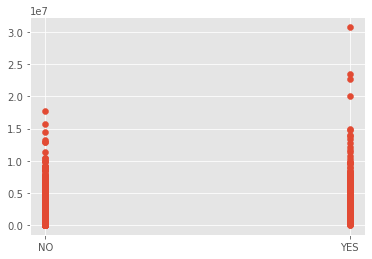

In [947]:
plt.scatter(x=df['waterfront'], y=df['price'])

In [948]:
df['nuisance'].unique()

array(['NO', 'YES'], dtype=object)

In [949]:
# convert nuisance into numeric boolean
nuisance_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.nuisance.replace(to_replace=nuisance_bool_dict,inplace=True)

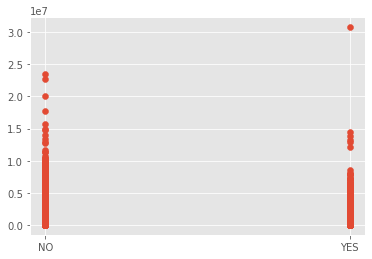

In [950]:
plt.scatter(x=df['nuisance'], y=df['price'])

In [951]:
# convert nuisance into numeric boolean
greenbelt_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.greenbelt.replace(to_replace=greenbelt_bool_dict,inplace=True)

In [952]:
df['view'].unique()

array(['NONE', 'AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD'], dtype=object)

In [953]:
# convert view from string into categorical ordinal
view_dict = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
df_categorical.view.replace(to_replace=view_dict,inplace=True)

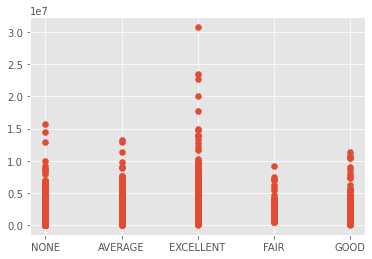

In [954]:
plt.scatter(x=df['view'], y=df['price'])

In [955]:
df['heat_source'].unique()

array(['Gas', 'Oil', 'Electricity', 'Gas/Solar', 'Electricity/Solar',
       'Other', 'Oil/Solar'], dtype=object)

In [956]:
heat_source_dummies = pd.get_dummies(df['heat_source'], prefix='heat_source',drop_first=True)
heat_source_dummies

,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other
0,0,1,0,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
30150,0,0,0,1,0,0
30151,0,1,0,0,0,0
30152,0,1,0,0,0,0
30153,0,1,0,0,0,0


In [957]:
df['sewer_system'].unique()

array(['PUBLIC', 'PRIVATE', 'PRIVATE RESTRICTED', 'PUBLIC RESTRICTED'],
      dtype=object)

In [958]:
sewer_dummies = pd.get_dummies(df['sewer_system'],prefix='sewer', drop_first=True)
sewer_dummies

,sewer_PRIVATE RESTRICTED,sewer_PUBLIC,sewer_PUBLIC RESTRICTED
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
30150,0,1,0
30151,0,1,0
30152,0,1,0
30153,0,1,0


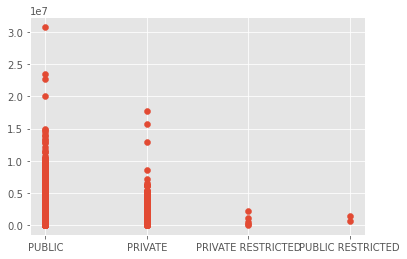

In [959]:
plt.scatter(x=df['sewer_system'], y=df['price'])

### Developing categorical dataframe

In [960]:
df_cat_pick = df_categorical[['waterfront','nuisance','view','greenbelt']]

## Model #2

In [961]:
model_2_data = pd.concat([df_numerical,sewer_dummies,heat_source_dummies, df_cat_pick], axis = 1)

In [962]:
len(model_2_data) == len(waterfront_dummies)

True

In [963]:
model_2_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_garage',
       'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'school_rating', 'month', 'day_of_year', 'sewer_PRIVATE RESTRICTED',
       'sewer_PUBLIC', 'sewer_PUBLIC RESTRICTED',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'waterfront', 'nuisance', 'view', 'greenbelt'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     1242.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:30:38   Log-Likelihood:            -4.2933e+05
No. Observations:               29200   AIC:                         8.587e+05
Df Residuals:                   29168   BIC:                         8.590e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

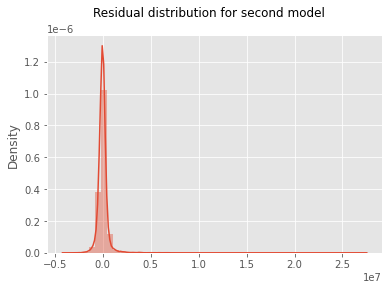

(None,
 Text(0.5, 0.98, 'Residual distribution for second model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [964]:
get_OLS_model('second',model_2_data, df['price'])

In [965]:
get_error_metrics(model_2_data,df['price'])

Mean Squared Error:  345564825409.89886
Root Mean Squared Error:  587847.6209102992
Mean Average Percentage Error:  38.276485540425995 %


`heat_source`, `greenbelt` and `sewer_system` both have incredibly high p-values. These will be dropped from the final model if it holds. 

## Observations of Model 2

Model is still highly skewed although did present itself with some improvements. Next steps will be to normalize the data by transforming features that are skewed within the data, as well as remove outliers

- Durbin Watson score is in the acceptable range of 1.50-2.50
- Rsquared has 'improved' but only at the expense of the the continued flaws mentioned before. 

## Eliminating Outliers

To normalize the distribution, outlier removal will be the first step. An outlier will be defined as three standard deviations away from the mean of the target variable.

In [966]:
# Get the 3rd and 97th percentiles of the dependent variable column
lower_percentile = df['price'].quantile(0.03)
upper_percentile = df['price'].quantile(0.97)

# Filter the DataFrame to exclude values outside the lower and upper percentiles
df_outlier_removed = df[(df['price'] > lower_percentile) & 
                 (df['price'] < upper_percentile)]

# Create a new DataFrame with only the dependent variable column
y = df_outlier_removed['price']

# Filter the model_2_data to exclude values outside the lower and upper percentiles
model_2_data_outlier_removed = model_2_data[(df['price'] > lower_percentile) &  (df['price'] < upper_percentile)]

In [967]:
df_outlier_removed

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,waterfront_loc,water_Elliot Bay,water_Lake Sammamish,water_Lake Union,water_Lake Washington,water_Puget Sound,water_other,school_rating,month,day_of_year
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,other,0,0,0,0,0,1,3.000000,5,144
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,other,0,0,0,0,0,1,6.250000,12,347
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,other,0,0,0,0,0,1,5.937338,12,348
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,other,0,0,0,0,0,1,6.750000,8,236
5,2807100156,2021-07-20,625000.0,2,1.0,1190,5688,1.0,NO,NO,...,other,0,0,0,0,0,1,6.250000,7,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,other,0,0,0,0,0,1,9.000000,11,334
30151,194000695,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,other,0,0,0,0,0,1,5.937338,6,167
30152,7960100080,2022-05-27,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,other,0,0,0,0,0,1,5.937338,5,147
30153,2781280080,2022-02-24,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,other,0,0,0,0,0,1,3.000000,2,55


In [968]:
waterfront_dummies = df_outlier_removed[['water_Elliot Bay','water_Lake Sammamish', 'water_Lake Washington','water_Puget Sound','water_other']]

In [969]:
df_outlier_removed.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'zipcode', 'waterfront_loc',
       'water_Elliot Bay', 'water_Lake Sammamish', 'water_Lake Union',
       'water_Lake Washington', 'water_Puget Sound', 'water_other',
       'school_rating', 'month', 'day_of_year'],
      dtype='object')

## New look at model with removed outliers

In [970]:
len(y)

27446

In [971]:
outlier_data = pd.concat([y,model_2_data_outlier_removed], axis=1)

In [972]:
outlier_data = outlier_data.drop('price', axis=1)

In [973]:
len(outlier_data)

27446

In [974]:
outlier_data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_garage,...,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,waterfront,nuisance,view,greenbelt
0,4,1.0,1180,7140,1.0,4,7,1180,0,0,...,0,1,0,0,0,0,0,0,0,0
1,5,2.5,2770,6703,1.0,3,7,1570,1570,0,...,0,0,0,1,0,0,0,1,2,0
3,3,3.0,2160,1400,2.0,3,9,1090,1070,200,...,0,1,0,0,0,0,0,0,2,0
4,2,2.0,1120,758,2.0,3,7,1120,550,550,...,0,0,0,0,0,0,0,1,0,0
5,2,1.0,1190,5688,1.0,3,7,1190,0,300,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,5,2.0,1910,4000,1.5,4,8,1600,1130,0,...,0,0,0,1,0,0,0,0,0,0
30151,3,2.0,2020,5800,2.0,3,7,2020,0,0,...,0,1,0,0,0,0,0,0,1,0
30152,3,2.0,1620,3600,1.0,3,7,940,920,240,...,0,1,0,0,0,0,0,1,0,0
30153,3,2.5,2570,2889,2.0,3,8,1830,740,480,...,0,1,0,0,0,0,0,0,0,0


## Model #3

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     1774.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:30:39   Log-Likelihood:            -3.8514e+05
No. Observations:               27446   AIC:                         7.704e+05
Df Residuals:                   27414   BIC:                         7.706e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

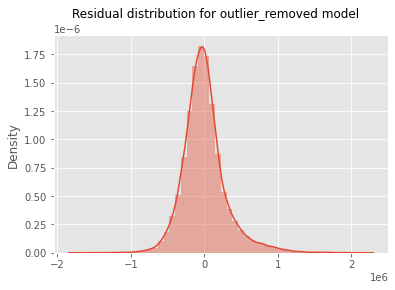

(None,
 Text(0.5, 0.98, 'Residual distribution for outlier_removed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [975]:
get_OLS_model('outlier_removed', outlier_data,y)

## Looking at RMSE, MAE, MAPE

In [976]:
get_error_metrics(outlier_data,y)

Mean Squared Error:  90418051636.01196
Root Mean Squared Error:  300695.9454931376
Mean Average Percentage Error:  22.330377104885844 %


In [977]:
outlier_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_garage',
       'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'school_rating', 'month', 'day_of_year', 'sewer_PRIVATE RESTRICTED',
       'sewer_PUBLIC', 'sewer_PUBLIC RESTRICTED',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'waterfront', 'nuisance', 'view', 'greenbelt'],
      dtype='object')

## Observations of model 3
pvalue > 0.05
- `sqft_basement` 
- `sqft_garage`
- `sewer_PRIVATE RESTRICTED`
- `sewer_PUBLIC RESTRICTED`
- `heat_source_Electricity/Solar`
- `heat_source_Oil/Solar`
- `heat_source_Other`



- Adjusted rsquared indicates that the model explains 62.2% of the data.
- Skewness has improved dramatically to an acceptable range between -2 and 2. The removal of outliers has made this possible.
- Durbin-Watson score is still in the acceptable ranges of 1.5-2.5
- Jarque-Bera score is still very high but has been brought down by a significant factor. Still not perfect but trending in the right direction.
- Multicollinearity is possibly present in the model and likely so given the initial VIFs before the first model was built. VIFS should be revisited again to see if those variables are worth keeping. 

## Looking at transformations for the price.

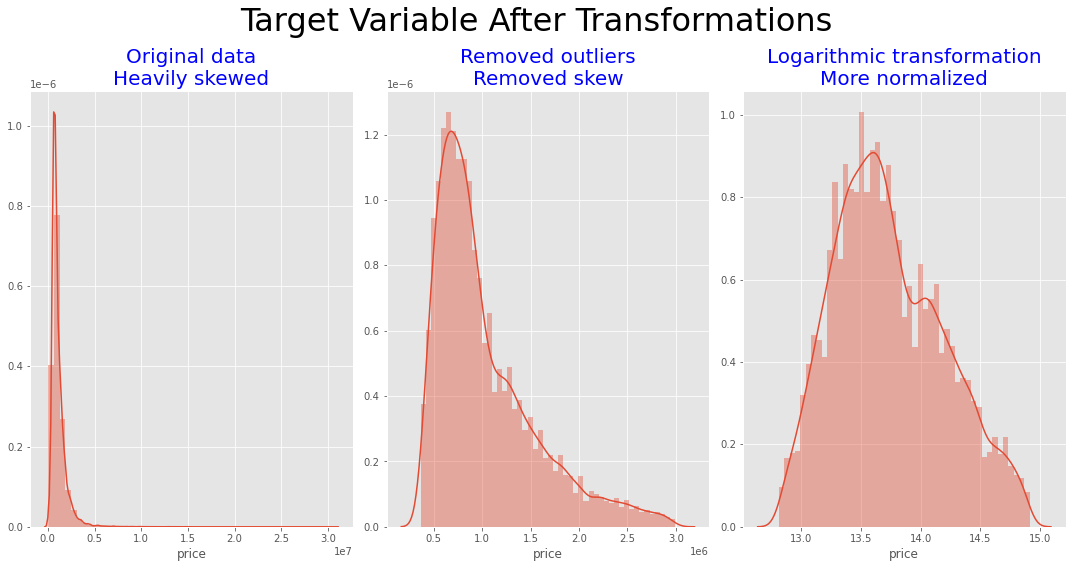

In [978]:
def plot_dist(ax, data, title):
    sns.distplot(data, ax=ax)
    ax.set_title(title, fontsize=20, color='b')
    ax.set_ylabel("")

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Plot the original data
plot_dist(ax1, df['price'], "Original data\nHeavily skewed")


# Plot the data with outliers removed
plot_dist(ax2, y, "Removed outliers\nRemoved skew")

# Apply square root transformation to the data
y_log = np.log(y)

# Plot the transformed data
plot_dist(ax3, y_log, "Logarithmic transformation\nMore normalized")

# Set the overall title of the figure
fig.suptitle("Target Variable After Transformations", fontsize=32)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the figure
plt.show()


### Checking model with transformed target variable - log transformation

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     2209.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:30:44   Log-Likelihood:                -345.54
No. Observations:               27446   AIC:                             755.1
Df Residuals:                   27414   BIC:                             1018.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

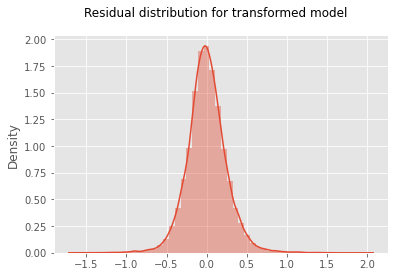

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [979]:
get_OLS_model('transformed', outlier_data, y_log)

In [980]:
def get_log_mse(X, y):
    model = sm.OLS(y, sm.add_constant(X))
    result = model.fit()

    # Calculate the predicted values of the target variable using the linear model
    y_pred = result.predict(sm.add_constant(X))
    
    return mean_squared_log_error(y, y_pred)
get_log_mse(outlier_data, y_log)

0.00027353634108759735

In [981]:
get_error_metrics(outlier_data, y)

Mean Squared Error:  90418051636.01196
Root Mean Squared Error:  300695.9454931376
Mean Average Percentage Error:  22.330377104885844 %


## Checking distribution of predictor

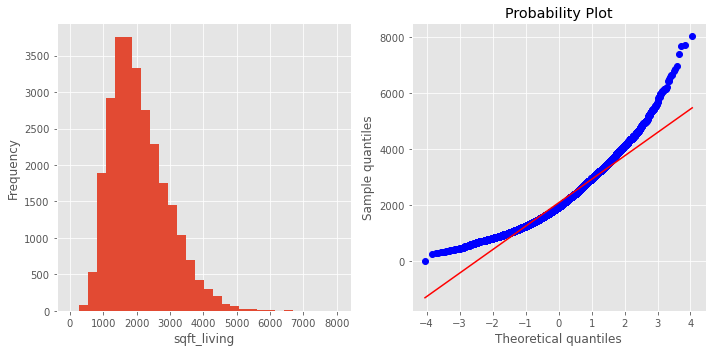

In [982]:
plot_hist_qq(outlier_data, 'sqft_living')

Data is clearly skewed right and follows an exponential pattern similar to price. For this, we will use a logarithmic transformation.

In [983]:
outlier_data['sqft_garage']

0          0
1          0
3        200
4        550
5        300
        ... 
30150      0
30151      0
30152    240
30153    480
30154    420
Name: sqft_garage, Length: 27446, dtype: int64

In [984]:
outlier_data['sqft_living_log'] = np.log(outlier_data['sqft_living']) 

In [985]:
outlier_data['sqft_above_log'] = np.log(outlier_data['sqft_above']) 
outlier_data['sqft_basement_log'] = np.log(outlier_data['sqft_basement']) 

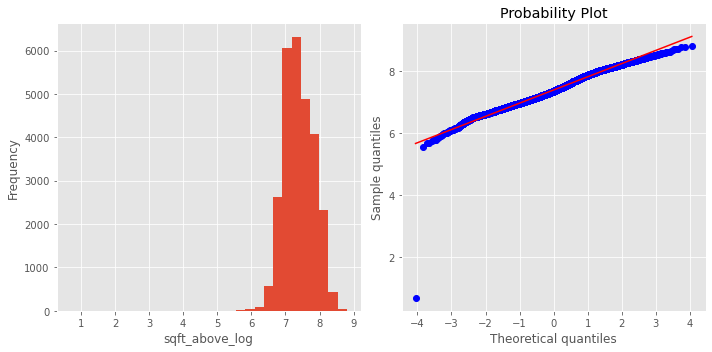

In [986]:
plot_hist_qq(outlier_data, 'sqft_above_log')

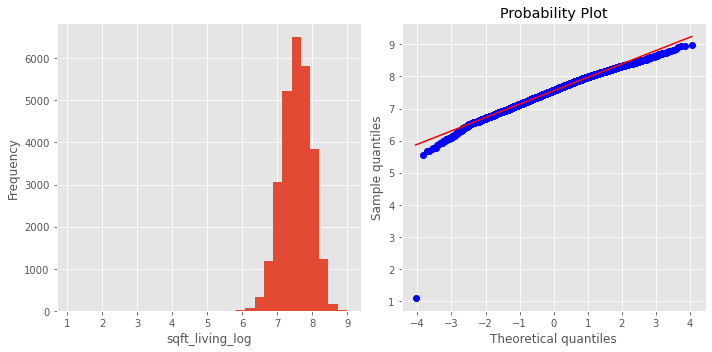

In [987]:
plot_hist_qq(outlier_data, 'sqft_living_log')

In [988]:
outlier_data = outlier_data.drop('sqft_living', axis=1)

In [989]:
outlier_data = outlier_data.drop(['sqft_basement_log','sqft_above'], axis=1)

In [990]:
outlier_data

,bedrooms,bathrooms,sqft_lot,floors,condition,grade,sqft_basement,sqft_garage,sqft_patio,yr_built,...,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,waterfront,nuisance,view,greenbelt,sqft_living_log,sqft_above_log
0,4,1.0,7140,1.0,4,7,0,0,40,1969,...,0,0,0,0,0,0,0,0,7.073270,7.073270
1,5,2.5,6703,1.0,3,7,1570,0,240,1950,...,0,1,0,0,0,1,2,0,7.926603,7.358831
3,3,3.0,1400,2.0,3,9,1070,200,270,2010,...,0,0,0,0,0,0,2,0,7.677864,6.993933
4,2,2.0,758,2.0,3,7,550,550,30,2012,...,0,0,0,0,0,1,0,0,7.021084,7.021084
5,2,1.0,5688,1.0,3,7,0,300,0,1948,...,0,0,0,0,0,1,0,0,7.081709,7.081709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,5,2.0,4000,1.5,4,8,1130,0,210,1921,...,0,1,0,0,0,0,0,0,7.554859,7.377759
30151,3,2.0,5800,2.0,3,7,0,0,520,2011,...,0,0,0,0,0,0,1,0,7.610853,7.610853
30152,3,2.0,3600,1.0,3,7,920,240,110,1995,...,0,0,0,0,0,1,0,0,7.390181,6.845880
30153,3,2.5,2889,2.0,3,8,740,480,100,2006,...,0,0,0,0,0,0,0,0,7.851661,7.512071


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     2157.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:30:48   Log-Likelihood:                -578.42
No. Observations:               27446   AIC:                             1221.
Df Residuals:                   27414   BIC:                             1484.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

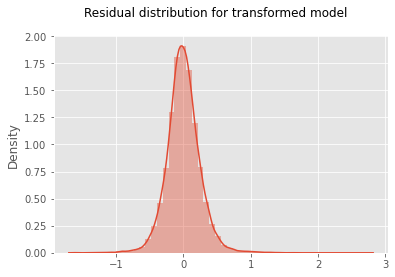

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [991]:
get_OLS_model('transformed', outlier_data, y_log)

In [992]:
get_error_metrics(outlier_data, y_log)

Mean Squared Error:  0.0610704553800042
Root Mean Squared Error:  0.2471243722905618
Mean Average Percentage Error:  1.329227711650429 %


In [993]:
get_log_mse(outlier_data, y_log)

0.00027919630760690826

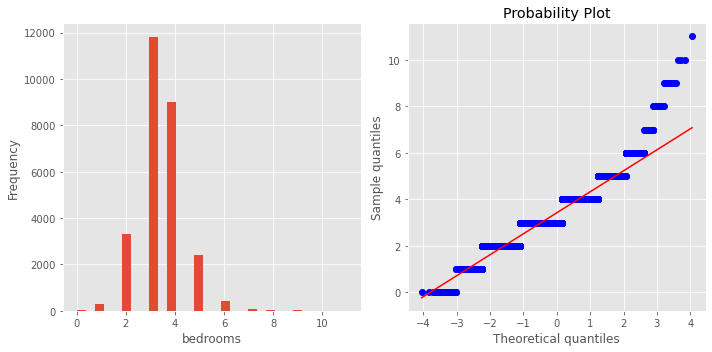

In [994]:
plot_hist_qq(outlier_data, 'bedrooms')

pval > 0.05

- `bedrooms` - will be dropped from the current model


In [995]:
outlier_data = outlier_data.drop(['bedrooms'], axis=1)

#### Rerun model

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     2229.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:30:50   Log-Likelihood:                -578.43
No. Observations:               27446   AIC:                             1219.
Df Residuals:                   27415   BIC:                             1474.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

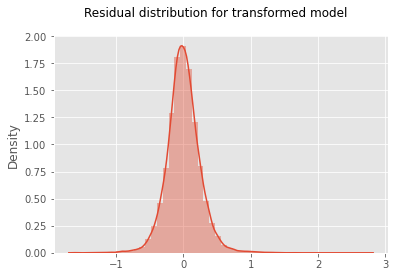

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [996]:
get_OLS_model('transformed', outlier_data, y_log)

### Dropping sewer/heat source data

In [997]:
new_outlier_data = outlier_data.drop(['sewer_PRIVATE RESTRICTED','sewer_PUBLIC RESTRICTED', 'heat_source_Oil', 'heat_source_Oil/Solar', 'heat_source_Other', 'heat_source_Electricity/Solar'], axis =1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     2784.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:30:52   Log-Likelihood:                -586.36
No. Observations:               27446   AIC:                             1223.
Df Residuals:                   27421   BIC:                             1428.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -30.33

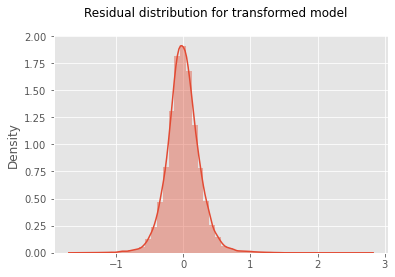

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [998]:
get_OLS_model('transformed', new_outlier_data, y_log)

In [999]:
get_error_metrics(outlier_data, y_log)

Mean Squared Error:  0.06107049591260175
Root Mean Squared Error:  0.24712445429904695
Mean Average Percentage Error:  1.329220342637079 %


In [1000]:
get_error_metrics(outlier_data, y)

Mean Squared Error:  95220005558.32008
Root Mean Squared Error:  308577.3899013343
Mean Average Percentage Error:  23.22399188172752 %


## Observations

- pval > 0.05

`bedrooms` - dropped from the current model

- all variables are statistically significant (pvalue < 0.05)
- Durbin-Watson Score continues to be "fine" but not improve a whole lot.
- Jarque-Bera Score continues to improve but still must come down
- skewness is now an afterthought as its at a very low -0.347
Overall no real improvement of the model happens here, we will try adding in new variables to improve as well as revisit VIFs to likely drop all that were originally at extremely high levels. 


Next steps to improve the model:
1. revisit VIFs to see if any variables(now that outliers are removed and data has been transformed) should now be dropped from the model. 
2. New predictors will be engineered to be added to the model. The next focus will be on the zipcodes in an attempt to narrow down the data with location-dependent price points. Possible data to be looked at are:
- waterfronts 
- views
- school districts: rating, and school taxes
- tax brackets



Jarque-Beras score and skew level continue to improve but there is still some work to do. 

## Rechecking VIFs

In [1001]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your data into a pandas DataFrame
data = new_outlier_data

# Get a list of the column names
cols = data.columns

# Create an empty DataFrame to hold the VIF results
vif_data = pd.DataFrame()

# Loop through each column and calculate the VIF
for i in range(len(cols)):
    vif = variance_inflation_factor(data[cols].values, i)
    vif_data = vif_data.append({'Variable': cols[i], 'VIF': vif}, ignore_index=True)

# Print the VIF results
print(vif_data)

                 Variable            VIF
0               bathrooms      24.585430
1                sqft_lot       1.272768
2                  floors      17.963674
3               condition      31.752875
4                   grade     136.876374
5           sqft_basement       5.547915
6             sqft_garage       4.712920
7              sqft_patio       2.268028
8                yr_built    9395.645709
9            yr_renovated       1.205844
10                    lat  155544.546934
11                   long  167482.287336
12          school_rating      26.465964
13                  month     698.007551
14            day_of_year     612.956164
15           sewer_PUBLIC       8.923106
16        heat_source_Gas       3.953563
17  heat_source_Gas/Solar       1.015903
18             waterfront       1.203274
19               nuisance       1.265885
20                   view       1.445364
21              greenbelt       1.069552
22        sqft_living_log    4042.140518
23         sqft_

## Scaling data

In [1002]:
scaledX = (new_outlier_data - np.mean(new_outlier_data)) / np.std(new_outlier_data)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     2784.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:30:56   Log-Likelihood:                -586.36
No. Observations:               27446   AIC:                             1223.
Df Residuals:                   27421   BIC:                             1428.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.73

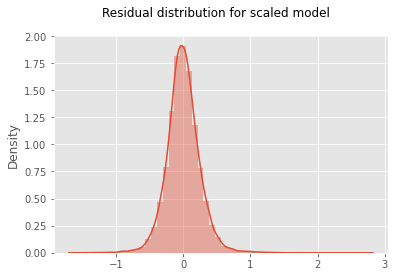

(None,
 Text(0.5, 0.98, 'Residual distribution for scaled model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [1003]:
get_OLS_model('scaled',scaledX, y_log)

In [1004]:
get_vifs(scaledX)

                 Variable         VIF
0               bathrooms    2.813452
1                sqft_lot    1.185815
2                  floors    2.180485
3               condition    1.264250
4                   grade    2.691863
5           sqft_basement    3.294265
6             sqft_garage    1.953769
7              sqft_patio    1.260659
8                yr_built    2.758570
9            yr_renovated    1.157342
10                    lat    1.583700
11                   long    1.772648
12          school_rating    1.566587
13                  month  116.889211
14            day_of_year  116.882368
15           sewer_PUBLIC    1.405877
16        heat_source_Gas    1.233890
17  heat_source_Gas/Solar    1.012836
18             waterfront    1.188791
19               nuisance    1.055259
20                   view    1.300162
21              greenbelt    1.050283
22        sqft_living_log   12.424688
23         sqft_above_log   11.527536


### Adding waterfront dummies to the model

In [1005]:
water_data = pd.concat([scaledX,waterfront_dummies], axis=1)

In [1006]:
water_data.columns

Index(['bathrooms', 'sqft_lot', 'floors', 'condition', 'grade',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'school_rating', 'month', 'day_of_year',
       'sewer_PUBLIC', 'heat_source_Gas', 'heat_source_Gas/Solar',
       'waterfront', 'nuisance', 'view', 'greenbelt', 'sqft_living_log',
       'sqft_above_log', 'water_Elliot Bay', 'water_Lake Sammamish',
       'water_Lake Washington', 'water_Puget Sound', 'water_other'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     2340.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:31:00   Log-Likelihood:                -436.14
No. Observations:               27446   AIC:                             932.3
Df Residuals:                   27416   BIC:                             1179.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.74

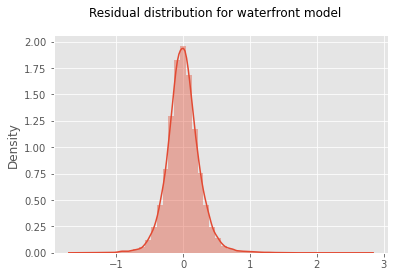

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [1007]:
get_OLS_model('waterfront',water_data,y_log)

Elliot Bay and Puget Sound present high pvalues indicating a lack of statistical significance. These will be dropped from the model. 

In [1008]:
water_data = water_data.drop(['water_other'], axis=1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     2423.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:31:01   Log-Likelihood:                -436.24
No. Observations:               27446   AIC:                             930.5
Df Residuals:                   27417   BIC:                             1169.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.73

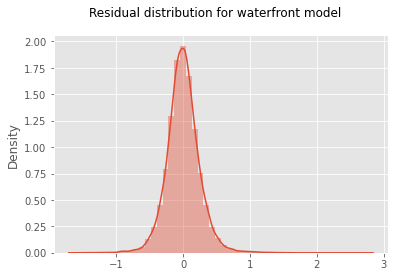

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [1009]:
get_OLS_model('waterfront',water_data,y_log)

## Recheck VIFs

In [1010]:
get_vifs(water_data)

                 Variable         VIF
0               bathrooms    2.815292
1                sqft_lot    1.189346
2                  floors    2.184048
3               condition    1.265736
4                   grade    2.718295
5           sqft_basement    3.304182
6             sqft_garage    1.966614
7              sqft_patio    1.262357
8                yr_built    2.772976
9            yr_renovated    1.158320
10                    lat    1.737909
11                   long    1.838453
12          school_rating    1.686288
13                  month  116.907328
14            day_of_year  116.899793
15           sewer_PUBLIC    1.497687
16        heat_source_Gas    1.235765
17  heat_source_Gas/Solar    1.013087
18             waterfront    1.193535
19               nuisance    1.056759
20                   view    1.302360
21              greenbelt    1.051093
22        sqft_living_log   12.432154
23         sqft_above_log   11.534209
24       water_Elliot Bay    1.067688
25   water_L

#### Month and day_of_year present with high variance inflation factors indicating possible collinearity. These will be dropped. 

In [1011]:
water_data = water_data.drop(['month','day_of_year','sqft_living_log'], axis =1)

In [1012]:
get_vifs(water_data)

                 Variable       VIF
0               bathrooms  2.578357
1                sqft_lot  1.189172
2                  floors  2.127025
3               condition  1.245391
4                   grade  2.682408
5           sqft_basement  1.739542
6             sqft_garage  1.931111
7              sqft_patio  1.260893
8                yr_built  2.742945
9            yr_renovated  1.156881
10                    lat  1.737904
11                   long  1.836777
12          school_rating  1.685785
13           sewer_PUBLIC  1.497604
14        heat_source_Gas  1.231800
15  heat_source_Gas/Solar  1.013061
16             waterfront  1.193478
17               nuisance  1.056396
18                   view  1.302207
19              greenbelt  1.051015
20         sqft_above_log  3.224589
21       water_Elliot Bay  1.067596
22   water_Lake Sammamish  1.196869
23  water_Lake Washington  1.163047
24      water_Puget Sound  1.048124


All VIFs are now below 3 aside from sqft_above, meaning the issue of collinearity is now for the most part solved. 

## Final model

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2566.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:31:10   Log-Likelihood:                -982.25
No. Observations:               27446   AIC:                             2017.
Df Residuals:                   27420   BIC:                             2230.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.73

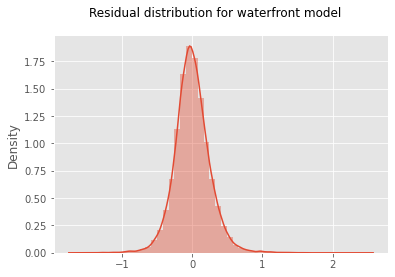

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [1013]:
get_OLS_model('waterfront',water_data,y_log)

## P-values of sqft_garage and Elliot bay are too high, to be dropped

In [1014]:
water_data = water_data.drop(['sqft_garage','water_Elliot Bay'], axis=1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2789.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:31:11   Log-Likelihood:                -983.64
No. Observations:               27446   AIC:                             2015.
Df Residuals:                   27422   BIC:                             2213.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.73

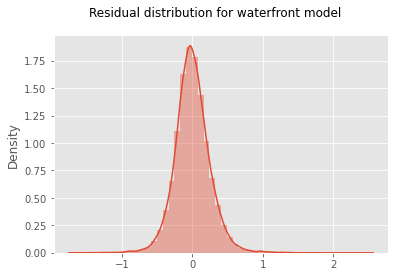

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [1015]:
get_OLS_model('waterfront',water_data,y_log)

In [1016]:
model = sm.OLS(y_log, sm.add_constant(water_data))
results = model.fit()
model_residual = results.resid
model_params = results.params

print(results.params)

const                    13.736608
bathrooms                 0.044602
sqft_lot                  0.028880
floors                   -0.019251
condition                 0.036807
grade                     0.130172
sqft_basement             0.040365
sqft_patio                0.015128
yr_built                 -0.050884
yr_renovated              0.012325
lat                       0.166207
long                      0.006676
school_rating             0.085132
sewer_PUBLIC              0.012971
heat_source_Gas           0.014910
heat_source_Gas/Solar     0.007111
waterfront                0.018251
nuisance                 -0.009396
view                      0.045831
greenbelt                 0.009246
sqft_above_log            0.146602
water_Lake Sammamish      0.090771
water_Lake Washington    -0.135775
water_Puget Sound        -0.039698
dtype: float64


### Raw Predictor vs. Log Transformed Target

We are modeling the relationship as:

$$ \large{ log(y) = \beta x \ldots } $$

For **small** values of $\beta$, we can interpret $\beta$ as:

> For each increase of $\large{1}$ unit in $\large{x}$, we see an associated change of $\large{(\beta * 100)}\%$ in $\large{y}$

Since the coefficients seem **small** due to them being scaled as z-scores, we will just multiply by 100 to convert to percentages.

In [1017]:
# Initializing Pandas DataFrame of params
params = pd.DataFrame(results.params)
params = params.reset_index()

#renaming columnss
params.columns = ['variable', 'coefficient']

#Labeling params as positive or negative
params['correlation'] = params['coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x<0 else x) 

#Converting to absolute values
params['coefficient'] = params['coefficient'].apply(lambda x: abs(x))

#Calculating Percent Change
params['percent_change'] = round(params["coefficient"] * 100, 2) 

# Sorting the 'params' in order of highest correlations, negative or positive.
params = params.sort_values('percent_change', ascending=False)
params[1:]

,variable,coefficient,correlation,percent_change
10,lat,0.166207,Positive,16.62
20,sqft_above_log,0.146602,Positive,14.66
22,water_Lake Washington,0.135775,Negative,13.58
5,grade,0.130172,Positive,13.02
21,water_Lake Sammamish,0.090771,Positive,9.08
12,school_rating,0.085132,Positive,8.51
8,yr_built,0.050884,Negative,5.09
18,view,0.045831,Positive,4.58
1,bathrooms,0.044602,Positive,4.46
6,sqft_basement,0.040365,Positive,4.04


## Iterating through the dataframe to write out interpretations

In [1018]:
for i, row in params.iterrows():
    if i == 0:
        pass
    elif row.correlation =='Positive':
        print(f'As {params.variable[i]} increases by 1 standard deviation, the price of a home increases by {round(params.percent_change[i], 2)}%\n')
    else:
        print(f'As {params.variable[i]} increases by 1 standard deviation, the price of a home decreases by {round(params.percent_change[i], 2)}%\n')


As lat increases by 1 standard deviation, the price of a home increases by 16.62%

As sqft_above_log increases by 1 standard deviation, the price of a home increases by 14.66%

As water_Lake Washington increases by 1 standard deviation, the price of a home decreases by 13.58%

As grade increases by 1 standard deviation, the price of a home increases by 13.02%

As water_Lake Sammamish increases by 1 standard deviation, the price of a home increases by 9.08%

As school_rating increases by 1 standard deviation, the price of a home increases by 8.51%

As yr_built increases by 1 standard deviation, the price of a home decreases by 5.09%

As view increases by 1 standard deviation, the price of a home increases by 4.58%

As bathrooms increases by 1 standard deviation, the price of a home increases by 4.46%

As sqft_basement increases by 1 standard deviation, the price of a home increases by 4.04%

As water_Puget Sound increases by 1 standard deviation, the price of a home decreases by 3.97%



## Final Observations

The results suggest that the most influential predictors on home price are:

`Latitude (lat)`: As latitude increases by 1 standard deviation, the price of a home increases by 16.62%.
`Grade`: As grade increases by 1 standard deviation, the price of a home increases by 13.02%.
`Square footage of aside from basement (sqft_above_log)`: As sqft_above_log increases by 1 standard deviation, the price of a home increases by 14.66%.
Other predictors that have a significant effect on home price include:

`Water features`: Lake Sammamish increases home price by 9.08%, while Lake Washington decreases it by 13.58% and Puget Sound decreases it by 3.97%.
`School rating`: As school rating increases by 1 standard deviation, the price of a home increases by 8.51%.
`Bathrooms`: As the number of bathrooms increases by 1 standard deviation, the price of a home increases by 4.46%.
`View`: As the view score increases by 1 standard deviation, the price of a home increases by 4.58%.
`Square footage of basement area (sqft_basement)`: As sqft_basement increases by 1 standard deviation, the price of a home increases by 4.04%.
`Condition`: As condition increases by 1 standard deviation, the price of a home increases by 3.68%.
`Square footage of the lot (sqft_lot)`: As sqft_lot increases by 1 standard deviation, the price of a home increases by 2.89%.
`Longitude (long)`: As `longitude` increases by 1 standard deviation, the price of a home increases by .67%.
Some predictors have a smaller effect on home price, such as `waterfront` increasing the price by 1.83%, while `floors` decreasing it by 1.93%.

## Conclusion
This entire process included the above described data engineering techniques, as well as an extensive look at transforming variables, feature selection and elimination through trial and error. Different transformations on the price for example were attempted to normalize the distribution, but the decision was made to use the square root transformation as it lended itself to dealing with the upper and lower tails of the distribution of the price more efficiently. 

The rest of the data cleaning process also included dropping or filling in of missing values, removal of outliers, one hot encoding categorical variables as well as dropping all variables that presented themselves with a high variance inflation factor. The use of QQplots and histograms were used to check the distribution of residuals. 


## Four assumptions
The decisions of the creation of this model were based on the four assumptions with the method of justification, which are:

1. Linearity assumption: Scatterplots of the variables should represent some level of linearity aka correlation to the target variable. The use of scatterplots and correlation matrices were the method of justification for this assumption. 

2. Normality Assumption: Use of QQplots and Residual histograms were the method for justifying normality. 
The normality assumption in linear regression models refers to the assumption that the residuals (i.e., the difference between the observed and predicted values) are normally distributed. This assumption is important because many statistical tests and procedures used in linear regression models rely on the assumption of normality, including hypothesis testing, confidence intervals, and prediction intervals.

One way to check for normality of the residuals is by using a Q-Q plot (quantile-quantile plot). A Q-Q plot is a graphical tool that compares the distribution of the residuals to a normal distribution. If the residuals are normally distributed, the points in the Q-Q plot should follow a straight line. Any deviation from the straight line indicates that the residuals are not normally distributed. Specifically, if the points in the Q-Q plot deviate from the straight line in the tails of the distribution, it suggests that the residuals have heavier tails than a normal distribution. On the other hand, if the points in the Q-Q plot deviate from the straight line in the center of the distribution, it suggests that the residuals have a skewed distribution.

Another way to check for normality of the residuals is by using a histogram. A histogram is a graph that shows the frequency distribution of the residuals. If the residuals are normally distributed, the histogram should have a bell-shaped curve, with the majority of the residuals near the mean and fewer residuals towards the tails of the distribution. Any deviation from the bell-shaped curve indicates that the residuals are not normally distributed.

3. Homoscedasticity: Durbin-Watson score close to 2 indicates that the errors are approximately normally distributed with constant variance.

A Durbin-Watson score close to 2 generally indicates that the model's errors are approximately homoscedastic (i.e., the variance of the errors is constant across all levels of the predictor variables).

This is because a score close to 2 suggests that the errors are approximately normally distributed with constant variance, which is a key assumption of many regression models. When the errors are homoscedastic, it means that the variability of the dependent variable is relatively constant across different levels of the independent variables, which allows for more accurate estimation of the coefficients and predictions of the model.

4. Multicollinearity: VIF scores for independent variables. 

Variance Inflation Factors (VIFs) are a measure used to assess the degree of multicollinearity in a multiple regression model. Multicollinearity occurs when two or more independent variables in a regression model are highly correlated with each other, which can make it difficult to interpret the individual effects of each variable on the dependent variable.


## Final assessment and thoughts of the model
- When plotted the model residuals show a normalized distribution, satisfying the normality assumption although with fairly long tails. This is something to be added into the future work. 
- The Durbin-Watson score is almost exactly 2, satisfying the assumption of homoscedasticity. 
- The linearity assumption was satisfied through a rigorous look at the plots and in general can be a difficult metric to validate. 
- The skew level of the data is well within the acceptable range of -2 to 2 which is a vast improvement from the original model which was originally above 10. 
- The kurtosis level is inside the acceptable range of -7 to 7 at a score of ~6.

- The Jarque Beras score is a massive 10720 which will require further investigation for future work. My instincts tell me there still may be some major outliers that may be affecting this score as the QQplots appear to be for the most part okay. 
- The assumption of no multicollinearity is satisfied due to the VIFs all remaining under 3 and the OLS model shows no signs as well.


## Recommendations

For the purposes of Zillows ability to choose inventory in the King County Real Estate Market, I recommend looking at properties that are near Lake Samammish or that are further north that also is accompanied with a waterfront. Since the grade, condition, and number of bathrooms appear positively correlated to the price it would make sense to try and buy older homes in the aforementioned areas as older homes tend to be cheaper in terms of price. Taking these homes and ensuring the grade and condition are of high quality through either pre-assessed purchases or renovations, along with possibly adding bathrooms can raise the price for resell value. Picking houses near school districts of high rating can have an impact as well. 

Houses towards the west as well as ones that present nuisances clearly result in lower prices, so my recommendation would be to avoid buying houses that fit these parameters as it may result in "holding the bag" scenarios which could lead to longer times held with inventory. 

The only invalid metric that should probably be ignored for now(but explored further) is the size of the garage negatively affecting the price. I would not consider this to be an accurate assessment, but I do not want to exclude it from the model. 


#### Questions model can answer:

- `Should the house be on a waterfront?`
- `How far north should the houses be?`
- `What age should the house have?`
- `What level of renovations need to be performed on the houses, and when?`
- `Will the house price be affected by common nuisances? (eg. noise, construction, bugs)`
- `How far west should the house be before one should lose interest of the purchase?`
- `What average quality of schools in the surrounding area?`

## Future Work

In the future work, it is worth revisiting the value of the homes on the remaining waterfronts and seeing if there is any statistical significance. More exploration is needed but was not ready to be presented at this time. 

The views that are highlighted in the column_names.md documentation can be explored and onehotencoded and could be a potential candidate feature. 

Jarque Beras score and outliers of the dataset should be further explored. The use of 3 standard deviations from the mean being the metric for outliers could be expanded slightly as it appears this was still affected in a major way. 

Any independent variables that presented with a Variance Inflation factor above 5 should be looked at again to see if multicollinearity is an issue with these particular variables. 

## Getting final model error metrics

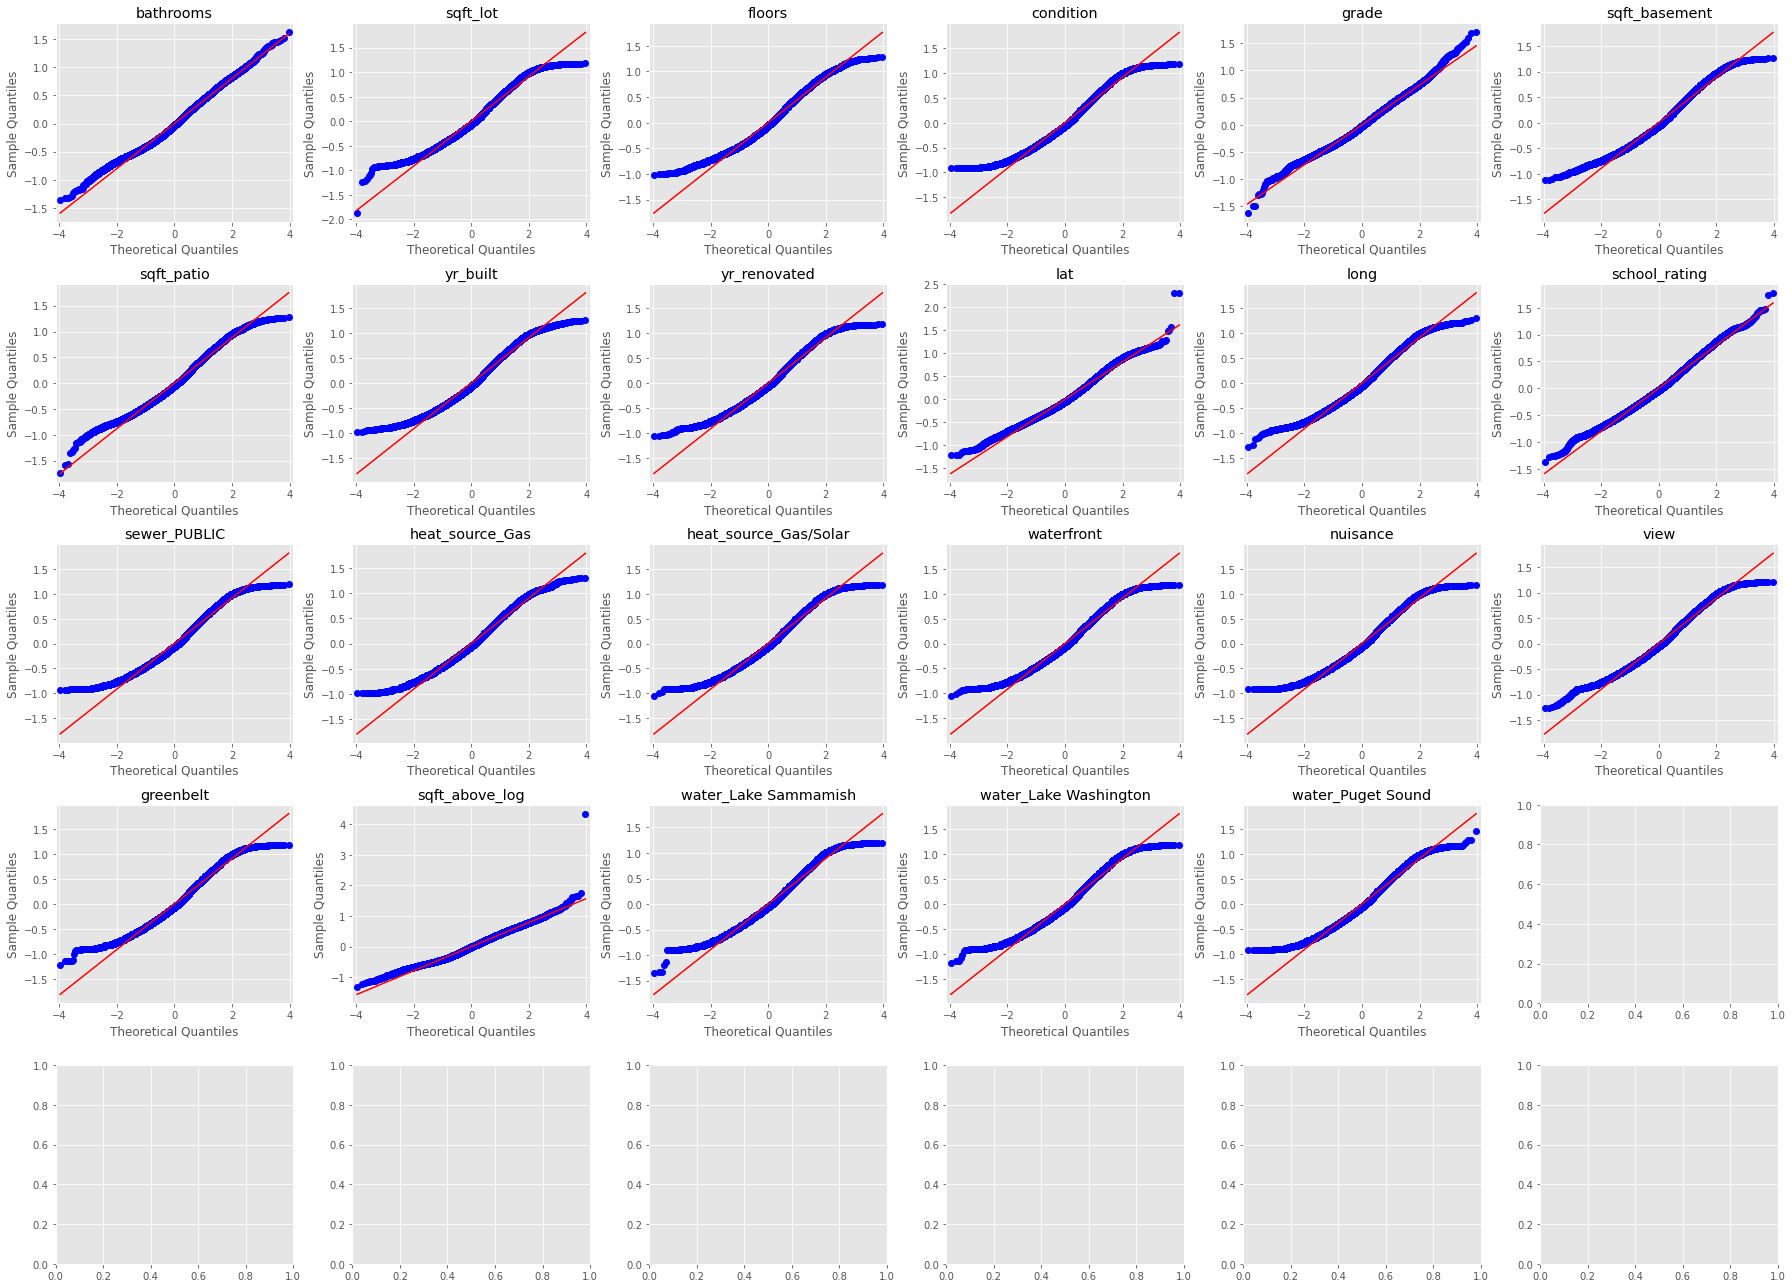

In [1019]:
get_model_qqplots(water_data, y_log)

In [1020]:
len(water_data)

27446